In [79]:
"""
Small VRP optimization using Large Neighborhood Search (LNS).
This approach allows for truly global optimization by destroying and rebuilding parts
of the solution, enabling clients to move between different vehicle routes.
"""

import os
import sys
import copy
import time
import random
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib.patches import Patch  # Add this import for the legend

# Set problem configuration
PROBLEM_SIZE = "small"
CAPACITIES = [100, 100, 100]  # Same capacity for all vehicles
VEHICLE_COUNTS = [2, 3, 4]    # We'll solve for these configurations

# LNS parameters - adjusted for smaller problem
MAX_ITERATIONS = 200
MAX_NO_IMPROVEMENT = 50
DESTROY_PERCENTAGE = 0.3  # Percentage of clients to remove in each iteration

In [80]:
def read_vrp_data(problem_size="small"):
    """Read VRP data from file."""
    import csv
    
    # Get current working directory to find data path
    if 'google.colab' in sys.modules:
        # For Google Colab, you might need to upload the data file
        from google.colab import files
        uploaded = files.upload()  # Will prompt to upload vrp.csv
        data_path = ''  # Current directory
    else:
        # Assume we're running locally
        script_path = os.getcwd()
        data_path = os.path.join(script_path, "data")
    
    print(f"Reading data for {problem_size}-vrp...")
    
    # Construct path to the clients data file
    vrp_data_path = os.path.join(data_path, f"{problem_size}-vrp", "vrp.csv")
    print(f"Looking for client data at: {vrp_data_path}")
    
    # Read client and depot data
    clients = []
    depot = None
    
    with open(vrp_data_path, mode="r") as file:
        reader = csv.DictReader(file, delimiter=";")
        for row in reader:
            node = {
                "ID": int(row["ID"]),
                "X": float(row["X"]),
                "Y": float(row["Y"]),
                "Demand": int(row["Demand"])
            }
            
            if node["ID"] == 0:  # Depot has ID 0
                depot = node
            else:
                clients.append(node)
    
    print(f"Read {len(clients)} clients and 1 depot.")
    return depot, clients

def calculate_distance(point1, point2):
    """Calculate Euclidean distance between two points."""
    return ((point1["X"] - point2["X"])**2 + (point1["Y"] - point2["Y"])**2)**0.5

def calculate_route_distance(route, client_map):
    """Calculate the total distance of a route."""
    distance = 0
    for i in range(len(route) - 1):
        from_node = client_map[route[i]]
        to_node = client_map[route[i + 1]]
        distance += calculate_distance(from_node, to_node)
    return distance

def calculate_total_distance(routes, client_map):
    """Calculate the total distance of all routes."""
    return sum(calculate_route_distance(route, client_map) for route in routes.values())

In [81]:
def apply_2opt(route, client_map, max_iterations=100):
    """Apply 2-opt optimization to a single route."""
    if len(route) <= 3:  # Route with 0 or 1 client can't be improved
        return route, calculate_route_distance(route, client_map)
    
    improved = True
    best_route = route.copy()
    best_distance = calculate_route_distance(route, client_map)
    
    iteration = 0
    while improved and iteration < max_iterations:
        improved = False
        iteration += 1
        
        for i in range(1, len(best_route) - 2):  # Skip depot at start
            for j in range(i + 1, len(best_route) - 1):  # Skip depot at end
                # Skip if segments are adjacent
                if j == i + 1:
                    continue
                    
                # Create new route with 2-opt swap
                # This reverses the segment between i and j
                new_route = best_route[:i] + best_route[i:j+1][::-1] + best_route[j+1:]
                
                # Calculate new distance
                new_distance = calculate_route_distance(new_route, client_map)
                
                # If better, keep it
                if new_distance < best_distance:
                    best_route = new_route
                    best_distance = new_distance
                    improved = True
                    break
            if improved:
                break
                
    return best_route, best_distance

In [82]:
def create_initial_solution(depot, clients, vehicles, client_map):
    """
    Create an initial solution using a simple assignment strategy.
    For small problems, we initialize with a balanced distribution.
    """
    # Initialize routes
    routes = {}
    for i, vehicle in enumerate(vehicles):
        vehicle_id = vehicle["Vehicle_ID"]
        routes[vehicle_id] = [0]  # Start at depot
    
    # Distribute clients evenly among vehicles initially
    for i, client in enumerate(clients):
        client_id = client["ID"]
        vehicle_id = vehicles[i % len(vehicles)]["Vehicle_ID"]
        routes[vehicle_id].append(client_id)
    
    # Add return to depot for all routes
    for vehicle_id in routes:
        routes[vehicle_id].append(0)
    
    # Apply 2-opt to each route
    for vehicle_id, route in routes.items():
        routes[vehicle_id], _ = apply_2opt(route, client_map)
    
    return routes

def destroy_solution(routes, percentage, client_map):
    """
    Destroy part of the solution by removing some clients.
    Returns the modified routes and a list of removed clients.
    """
    # Flatten all client IDs (excluding depots)
    all_clients = []
    for route in routes.values():
        all_clients.extend([node for node in route if node != 0])
    
    # Calculate how many clients to remove
    remove_count = max(1, int(len(all_clients) * percentage))
    
    # Randomly select clients to remove
    clients_to_remove = random.sample(all_clients, remove_count)
    
    # Remove selected clients from routes
    new_routes = copy.deepcopy(routes)
    for vehicle_id, route in new_routes.items():
        new_route = [0]  # Start with depot
        for node in route:
            if node != 0 and node in clients_to_remove:
                continue  # Skip removed clients
            elif node != 0:
                new_route.append(node)
        
        if len(new_route) > 1:  # If route has at least one client
            new_route.append(0)  # End with depot
            new_routes[vehicle_id] = new_route
        else:
            new_routes[vehicle_id] = [0, 0]  # Empty route (just depot to depot)
    
    return new_routes, clients_to_remove

def repair_solution(routes, removed_clients, client_map, vehicles, depot, clients):
    """
    Repair the solution by inserting removed clients back into routes.
    Uses a greedy insertion heuristic.
    """
    # Create a map of clients for easy access
    clients_data = {client["ID"]: client for client in clients}
    
    # Track vehicle loads
    vehicle_loads = {}
    for vehicle_id, route in routes.items():
        vehicle_loads[vehicle_id] = sum(clients_data[node]["Demand"] 
                                      for node in route if node != 0)
    
    # Get vehicle capacities
    vehicle_capacities = {v["Vehicle_ID"]: v["Capacity"] for v in vehicles}
    
    # Sort removed clients by demand (descending) to insert larger demands first
    removed_clients.sort(key=lambda x: clients_data[x]["Demand"], reverse=True)
    
    # Insert each removed client at the best position
    for client_id in removed_clients:
        client_demand = clients_data[client_id]["Demand"]
        
        best_insertion = None
        best_insertion_cost = float('inf')
        
        # Try insertion in each route
        for vehicle_id, route in routes.items():
            # Skip if vehicle capacity would be exceeded
            if vehicle_loads[vehicle_id] + client_demand > vehicle_capacities[vehicle_id]:
                continue
                
            # Try each insertion position
            for i in range(1, len(route)):  # Skip inserting at position 0 (depot)
                # Create new route with client inserted
                new_route = route[:i] + [client_id] + route[i:]
                
                # Calculate insertion cost (increase in route distance)
                original_dist = calculate_route_distance(route, client_map)
                new_dist = calculate_route_distance(new_route, client_map)
                insertion_cost = new_dist - original_dist
                
                if insertion_cost < best_insertion_cost:
                    best_insertion = (vehicle_id, i)
                    best_insertion_cost = insertion_cost
        
        # Insert client at best position
        if best_insertion:
            vehicle_id, position = best_insertion
            routes[vehicle_id].insert(position, client_id)
            vehicle_loads[vehicle_id] += client_demand
        else:
            # If no insertion possible, create a new route
            # Find first vehicle without a route
            for vehicle in vehicles:
                vehicle_id = vehicle["Vehicle_ID"]
                if vehicle_id not in routes or routes[vehicle_id] == [0, 0]:
                    routes[vehicle_id] = [0, client_id, 0]
                    vehicle_loads[vehicle_id] = client_demand
                    break
    
    # Apply 2-opt to each route
    for vehicle_id, route in routes.items():
        if len(route) > 3:  # Only apply to routes with at least 2 clients
            routes[vehicle_id], _ = apply_2opt(route, client_map)
    
    return routes

In [83]:
def large_neighborhood_search(depot, clients, vehicles):
    """
    Implement Large Neighborhood Search for VRP optimization.
    
    Returns both initial solution and optimized solution for comparison.
    """
    print(f"Starting LNS with {len(vehicles)} vehicles of capacity {vehicles[0]['Capacity']}...")
    start_time = time.time()
    
    # Create client map for easier access
    client_map = {client["ID"]: client for client in clients}
    client_map[0] = depot  # Add depot
    
    # Create initial solution
    initial_solution = create_initial_solution(depot, clients, vehicles, client_map)
    initial_distance = calculate_total_distance(initial_solution, client_map)
    
    # Save the initial solution for comparison
    current_solution = copy.deepcopy(initial_solution)
    current_distance = initial_distance
    
    # Save best solution
    best_solution = copy.deepcopy(current_solution)
    best_distance = current_distance
    
    print(f"Initial solution distance: {initial_distance:.2f}")
    
    # LNS iterations
    iteration = 0
    iterations_no_improvement = 0
    
    while iteration < MAX_ITERATIONS and iterations_no_improvement < MAX_NO_IMPROVEMENT:
        iteration += 1
        
        # Destroy part of the solution
        destroyed_solution, removed_clients = destroy_solution(
            current_solution, DESTROY_PERCENTAGE, client_map
        )
        
        # Repair the solution
        repaired_solution = repair_solution(
            destroyed_solution, removed_clients, client_map, vehicles, depot, clients
        )
        
        # Calculate the new distance
        new_distance = calculate_total_distance(repaired_solution, client_map)
        
        # Accept the new solution if it's better
        if new_distance < current_distance:
            current_solution = copy.deepcopy(repaired_solution)
            current_distance = new_distance
            iterations_no_improvement = 0
            
            # Update best solution if improved
            if new_distance < best_distance:
                best_solution = copy.deepcopy(repaired_solution)
                best_distance = new_distance
                print(f"Iteration {iteration}: New best distance: {best_distance:.2f}")
        else:
            iterations_no_improvement += 1
        
        # Simple progress report
        if iteration % 50 == 0:
            print(f"Iteration {iteration}: Current distance: {current_distance:.2f}, " +
                  f"Best: {best_distance:.2f}, No improvement: {iterations_no_improvement}")
    
    # Calculate how many vehicles are actually used
    used_vehicles = sum(1 for route in best_solution.values() if len(route) > 2)
    
    end_time = time.time()
    print(f"LNS completed in {end_time - start_time:.2f} seconds")
    print(f"Initial distance: {initial_distance:.2f}")
    print(f"Final best distance: {best_distance:.2f}")
    print(f"Improvement: {(initial_distance - best_distance) / initial_distance * 100:.2f}%")
    print(f"Vehicles used: {used_vehicles} out of {len(vehicles)}")
    
    return best_solution, best_distance, initial_solution, initial_distance

In [84]:
def plot_vrp_solution(depot, clients, routes, title="VRP Solution", compare_original=None):
    """
    Plot the VRP solution with different colors for different vehicle routes.
    """
    # Create a mapping from client ID to client data
    client_map = {client["ID"]: client for client in clients}
    client_map[0] = depot  # Add depot
    
    # Setup figure
    if compare_original:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        fig.suptitle(title, fontsize=16)
        axes = [ax1, ax2]
        solutions = [compare_original, routes]
        subtitles = ["Original Solution", "Optimized Solution"]
    else:
        fig, ax = plt.subplots(figsize=(10, 8))
        axes = [ax]
        solutions = [routes]
        subtitles = [title]
    
    # Plot each solution
    for ax, subtitle, solution in zip(axes, subtitles, solutions):
        # Plot clients with size based on demand
        client_x = [client["X"] for client in clients]
        client_y = [client["Y"] for client in clients]
        demands = [client["Demand"] for client in clients]
        
        ax.scatter(client_x, client_y, c="blue", label="Clients", 
                 s=[d * 5 for d in demands], alpha=0.7)
        
        # Plot depot
        ax.scatter(depot["X"], depot["Y"], c="red", label="Depot", 
                 s=100, marker="X")
        
        # Plot routes with different colors
        colors = plt.cm.tab10.colors
        
        # Calculate total distance for subtitle
        total_distance = 0
        for vehicle_id, route in solution.items():
            if len(route) > 1:
                total_distance += calculate_route_distance(route, client_map)
        
        # Update subtitle
        ax.set_title(f"{subtitle}\nTotal Distance: {total_distance:.2f}")
        
        # Plot each route
        for i, (vehicle_id, route) in enumerate(solution.items()):
            if len(route) <= 2:  # Skip empty routes
                continue
                
            route_x = [client_map[client_id]["X"] for client_id in route]
            route_y = [client_map[client_id]["Y"] for client_id in route]
            
            color = colors[i % len(colors)]
            ax.plot(route_x, route_y, c=color, label=f"Vehicle {vehicle_id}", 
                   linewidth=2, alpha=0.8)
            
            # Add arrows to show direction
            for j in range(len(route) - 1):
                dx = route_x[j+1] - route_x[j]
                dy = route_y[j+1] - route_y[j]
                ax.arrow(route_x[j], route_y[j], dx * 0.9, dy * 0.9, 
                       head_width=3, head_length=3, fc=color, ec=color, alpha=0.7)
                       
            # Add vehicle ID label near first client
            if len(route) > 2:
                first_client_idx = 1  # First client after depot
                ax.annotate(f"V{vehicle_id}", 
                          (route_x[first_client_idx], route_y[first_client_idx]),
                          xytext=(5, 5), textcoords='offset points',
                          color=color, weight='bold')
        
        # Add labels and grid
        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")
        ax.grid(True, alpha=0.3)
        
        # Set legend location based on plot type
        if compare_original:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), 
                     ncol=3, fontsize='small')
        else:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    
    # In Jupyter, we'll just display the plot instead of saving it
    plt.show()
    
    return fig

In [85]:
def solve_small_vrp_with_different_vehicle_counts():
    """
    Solve the small VRP problem with 2, 3, and 4 vehicles, all with capacity 100.
    Compare the results to find the best configuration.
    """
    print(f"\n{'='*50}")
    print("SOLVING SMALL VRP WITH DIFFERENT VEHICLE CONFIGURATIONS")
    print(f"{'='*50}\n")
    
    try:
        # Read data
        depot, clients = read_vrp_data(PROBLEM_SIZE)
        
        print(f"Problem size: {len(clients)} clients")
        print(f"Total client demand: {sum(c['Demand'] for c in clients)}")
        
        # Results storage
        results = {}
        
        # Solve for each vehicle configuration
        for vehicle_count in VEHICLE_COUNTS:
            print(f"\n{'-'*50}")
            print(f"CONFIGURATION: {vehicle_count} vehicles with capacity 100")
            print(f"{'-'*50}")
            
            # Create vehicles with the specified configuration
            vehicles = [
                {"Vehicle_ID": i, "Capacity": 100}
                for i in range(1, vehicle_count + 1)
            ]
            
            # Solve with Large Neighborhood Search
            print(f"Solving with {vehicle_count} vehicles...")
            lns_routes, lns_distance = large_neighborhood_search(depot, clients, vehicles)
            
            # Store results
            results[vehicle_count] = {
                "routes": lns_routes,
                "distance": lns_distance,
                "vehicles_used": sum(1 for route in lns_routes.values() if len(route) > 2)
            }
            
            # Create client map for calculations
            client_map = {client["ID"]: client for client in clients}
            client_map[0] = depot
            
            # Report vehicle usage
            print("\nVehicle usage:")
            used_vehicles = 0
            
            for vehicle_id, route in lns_routes.items():
                if len(route) <= 2:  # Empty route
                    continue
                    
                used_vehicles += 1
                route_demand = sum(client_map[node_id]["Demand"] for node_id in route if node_id != 0)
                route_distance = calculate_route_distance(route, client_map)
                client_count = len(route) - 2  # Subtract 2 for depot at start and end
                capacity = 100  # All vehicles have capacity 100
                
                print(f"Vehicle {vehicle_id}: {client_count} clients, " + 
                      f"demand: {route_demand}/{capacity} " +
                      f"({route_demand/capacity*100:.1f}%), distance: {route_distance:.2f}")
            
            print(f"\nTotal vehicles used: {used_vehicles} out of {vehicle_count}")
            print(f"Total distance: {lns_distance:.2f}")
            
            # Plot solution
            plot_vrp_solution(depot, clients, lns_routes, 
                             f"Small VRP - {vehicle_count} Vehicles")
        
        # Compare all solutions
        print("\n\nCOMPARISON OF ALL CONFIGURATIONS:")
        print(f"{'Vehicles':<10} {'Distance':<15} {'Vehicles Used':<15}")
        print(f"{'-'*40}")
        
        for vehicle_count, result in sorted(results.items()):
            print(f"{vehicle_count:<10} {result['distance']:<15.2f} {result['vehicles_used']:<15}")
        
        # Find best configuration
        best_config = min(results.items(), key=lambda x: x[1]['distance'])
        print(f"\nBest configuration: {best_config[0]} vehicles with distance {best_config[1]['distance']:.2f}")
        
        return results
        
    except Exception as e:
        print(f"Error solving small VRP: {e}")
        import traceback
        traceback.print_exc()
        return None

In [86]:
# Run the solver for all configurations
results = solve_small_vrp_with_different_vehicle_counts()

# Create a DataFrame for easier visualization of the comparison
if results:
    # Load the data again to get depot and clients
    depot, clients = read_vrp_data(PROBLEM_SIZE)
    
    comparison_data = []
    for vehicle_count, result in results.items():
        # Create client map for calculations
        client_map = {client["ID"]: client for client in clients}
        client_map[0] = depot
        
        # Calculate capacity utilization
        total_demand = 0
        for vehicle_id, route in result['routes'].items():
            if len(route) > 2:  # Non-empty route
                route_demand = sum(client_map[node_id]["Demand"] for node_id in route if node_id != 0)
                total_demand += route_demand
        
        total_capacity = vehicle_count * 100
        capacity_utilization = (total_demand / total_capacity) * 100
        
        comparison_data.append({
            'Vehicle Count': vehicle_count,
            'Total Distance': result['distance'],
            'Vehicles Used': result['vehicles_used'],
            'Capacity Utilization (%)': capacity_utilization
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df)
    
    # Visualize the comparison
    plt.figure(figsize=(10, 6))
    plt.bar(comparison_df['Vehicle Count'], comparison_df['Total Distance'], color='skyblue')
    plt.xlabel('Number of Vehicles')
    plt.ylabel('Total Distance')
    plt.title('Total Distance by Vehicle Configuration')
    plt.xticks(comparison_df['Vehicle Count'])
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on top of bars
    for i, distance in enumerate(comparison_df['Total Distance']):
        plt.text(comparison_df['Vehicle Count'][i], distance + 5, f'{distance:.2f}', 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


SOLVING SMALL VRP WITH DIFFERENT VEHICLE CONFIGURATIONS

Reading data for small-vrp...
Looking for client data at: c:\Users\hseba\Desktop\Data_Science\Data_Science_MSc\6004_Inteligencia_Artificial\WS-USFQ\WS-USFQ\ProyectoFinal\VRP\data\small-vrp\vrp.csv
Read 10 clients and 1 depot.
Problem size: 10 clients
Total client demand: 115

--------------------------------------------------
CONFIGURATION: 2 vehicles with capacity 100
--------------------------------------------------
Solving with 2 vehicles...
Starting LNS with 2 vehicles of capacity 100...
Initial solution distance: 848.68
Iteration 1: New best distance: 789.01
Iteration 3: New best distance: 787.59
Iteration 4: New best distance: 647.91
Iteration 5: New best distance: 643.62
Iteration 50: Current distance: 643.62, Best: 643.62, No improvement: 45
LNS completed in 0.03 seconds
Initial distance: 848.68
Final best distance: 643.62
Improvement: 24.16%
Vehicles used: 2 out of 2
Error solving small VRP: too many values to unpack (

Traceback (most recent call last):
  File "C:\Users\hseba\AppData\Local\Temp\ipykernel_23544\584007625.py", line 34, in solve_small_vrp_with_different_vehicle_counts
    lns_routes, lns_distance = large_neighborhood_search(depot, clients, vehicles)
ValueError: too many values to unpack (expected 2)


In [87]:
# Set problem size to medium
PROBLEM_SIZE = "medium"

# LNS parameters - adjusted for medium problem
MAX_ITERATIONS = 300  # Increased for medium problem
MAX_NO_IMPROVEMENT = 70
DESTROY_PERCENTAGE = 0.25

def solve_medium_vrp_with_various_vehicle_counts():
    """
    Solve the medium VRP problem with various numbers of vehicles
    to find the optimal count, all with capacity 100.
    """
    print(f"\n{'='*50}")
    print("SOLVING MEDIUM VRP WITH DIFFERENT VEHICLE COUNTS (CAPACITY=100)")
    print(f"{'='*50}\n")
    
    CAPACITY = 100
    # Test more vehicle configurations for medium size
    VEHICLE_COUNTS = [6, 7, 8, 9, 10]  # Added higher vehicle counts
    
    try:
        # Read data
        depot, clients = read_vrp_data(PROBLEM_SIZE)
        
        print(f"Problem size: {len(clients)} clients")
        print(f"Total client demand: {sum(c['Demand'] for c in clients)}")
        total_demand = sum(c['Demand'] for c in clients)
        print(f"Minimum theoretical vehicles needed: {total_demand/CAPACITY:.2f}")
        
        # Results storage
        results = {}
        valid_results = {}  # Store only valid results
        
        # Solve for each vehicle configuration
        for vehicle_count in VEHICLE_COUNTS:
            print(f"\n{'-'*50}")
            print(f"CONFIGURATION: {vehicle_count} vehicles with capacity {CAPACITY}")
            print(f"{'-'*50}")
            
            # Skip configurations that are clearly insufficient
            if vehicle_count * CAPACITY < total_demand:
                print(f"Skipping - {vehicle_count} vehicles with capacity {CAPACITY} " +
                      f"is insufficient for total demand {total_demand}")
                continue
            
            # Create vehicles with the specified configuration
            vehicles = [
                {"Vehicle_ID": i, "Capacity": CAPACITY}
                for i in range(1, vehicle_count + 1)
            ]
            
            # Solve with Large Neighborhood Search
            lns_routes, lns_distance = large_neighborhood_search(depot, clients, vehicles)
            
            # Create client map for calculations
            client_map = {client["ID"]: client for client in clients}
            client_map[0] = depot
            
            # Validate if all clients are visited
            clients_in_solution = set()
            for route in lns_routes.values():
                for node_id in route:
                    if node_id != 0:  # Skip depot
                        clients_in_solution.add(node_id)
            
            all_clients_visited = len(clients_in_solution) == len(clients)
            
            # Store results
            results[vehicle_count] = {
                "routes": lns_routes,
                "distance": lns_distance,
                "vehicles_used": sum(1 for route in lns_routes.values() if len(route) > 2),
                "all_clients_visited": all_clients_visited,
                "clients_visited": len(clients_in_solution),
                "total_clients": len(clients)
            }
            
            # Only consider valid solutions for best configuration
            if all_clients_visited:
                valid_results[vehicle_count] = results[vehicle_count]
            
            # Report solution details including validation
            print(f"\nClients visited: {len(clients_in_solution)}/{len(clients)}")
            if not all_clients_visited:
                print(f"WARNING: Not all clients are visited in this solution!")
                # Print which clients are missing
                missing_clients = set(client["ID"] for client in clients) - clients_in_solution
                print(f"Missing clients: {missing_clients}")
            
            # Report vehicle usage and plot solution
            report_solution(depot, clients, lns_routes, client_map, vehicle_count, CAPACITY)
        
        # Compare all configurations, highlighting invalid solutions
        compare_results_with_validation(results, valid_results)
        
        return results, valid_results
    
    except Exception as e:
        print(f"Error solving medium VRP: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def compare_results_with_validation(results, valid_results):
    """Compare and visualize results from different vehicle counts, highlighting valid solutions."""
    print("\n\nCOMPARISON OF ALL CONFIGURATIONS:")
    print(f"{'Vehicles':<10} {'Distance':<15} {'Vehicles Used':<15} {'Clients Visited':<15} {'Valid':<10}")
    print(f"{'-'*65}")
    
    for vehicle_count, result in sorted(results.items()):
        valid_mark = "✓" if result["all_clients_visited"] else "✗"
        print(f"{vehicle_count:<10} {result['distance']:<15.2f} {result['vehicles_used']:<15} "
              f"{result['clients_visited']}/{result['total_clients']:<10} {valid_mark}")
    
    # Find best valid configuration
    if valid_results:
        best_valid_config = min(valid_results.items(), key=lambda x: x[1]['distance'])
        print(f"\nBest VALID configuration: {best_valid_config[0]} vehicles with distance {best_valid_config[1]['distance']:.2f}")
    else:
        print("\nNo valid configurations found! Increase vehicle count or capacity.")
    
    # Create visualization with color-coding for valid/invalid
    comparison_data = []
    for vehicle_count, result in results.items():
        comparison_data.append({
            'Vehicle Count': vehicle_count,
            'Total Distance': result['distance'],
            'Vehicles Used': result['vehicles_used'],
            'Valid': result['all_clients_visited'],
            'Clients Visited': f"{result['clients_visited']}/{result['total_clients']}"
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df)
    
    # Plot comparison with color coding
    plt.figure(figsize=(12, 6))
    
    # Create color map based on validity
    colors = ['lightcoral' if not row['Valid'] else 'skyblue' 
              for _, row in comparison_df.iterrows()]
    
    bars = plt.bar(comparison_df['Vehicle Count'], comparison_df['Total Distance'], color=colors)
    plt.xlabel('Number of Vehicles')
    plt.ylabel('Total Distance')
    plt.title('Total Distance by Vehicle Configuration (Red = Invalid Solution)')
    plt.xticks(comparison_df['Vehicle Count'])
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on top of bars with validity information
    for i, (_, row) in enumerate(comparison_df.iterrows()):
        visited_info = row['Clients Visited']
        distance = row['Total Distance']
        plt.text(row['Vehicle Count'], distance + 5, 
                f"{distance:.2f}\n({visited_info})", 
                ha='center', va='bottom')
    
    # Add a legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='skyblue', label='Valid Solution (All Clients)'),
        Patch(facecolor='lightcoral', label='Invalid Solution (Missing Clients)')
    ]
    plt.legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.show()

In [88]:
def solve_medium_vrp_with_various_capacities():
    """
    Solve the medium VRP problem with 4 vehicles and varying capacities
    to find the optimal capacity.
    """
    print(f"\n{'='*50}")
    print("SOLVING MEDIUM VRP WITH 4 VEHICLES AND DIFFERENT CAPACITIES")
    print(f"{'='*50}\n")
    
    VEHICLE_COUNT = 4
    # Test different capacities
    CAPACITIES = [150, 160, 170, 180]
    
    try:
        # Read data
        depot, clients = read_vrp_data(PROBLEM_SIZE)
        
        print(f"Problem size: {len(clients)} clients")
        print(f"Total client demand: {sum(c['Demand'] for c in clients)}")
        total_demand = sum(c['Demand'] for c in clients)
        min_capacity = total_demand / VEHICLE_COUNT
        print(f"Minimum theoretical capacity needed: {min_capacity:.2f}")
        
        # Results storage
        results = {}
        
        # Solve for each capacity
        for capacity in CAPACITIES:
            print(f"\n{'-'*50}")
            print(f"CONFIGURATION: {VEHICLE_COUNT} vehicles with capacity {capacity}")
            print(f"{'-'*50}")
            
            # Skip if capacity is clearly insufficient
            if capacity * VEHICLE_COUNT < total_demand:
                print(f"Capacity {capacity} is insufficient for total demand {total_demand}")
                continue
            
            # Create vehicles with the specified configuration
            vehicles = [
                {"Vehicle_ID": i, "Capacity": capacity}
                for i in range(1, VEHICLE_COUNT + 1)
            ]
            
            # Solve with Large Neighborhood Search
            lns_routes, lns_distance = large_neighborhood_search(depot, clients, vehicles)
            
            # Store results
            results[capacity] = {
                "routes": lns_routes,
                "distance": lns_distance,
                "vehicles_used": sum(1 for route in lns_routes.values() if len(route) > 2)
            }
            
            # Create client map for calculations
            client_map = {client["ID"]: client for client in clients}
            client_map[0] = depot
            
            # Report vehicle usage and plot solution
            report_solution(depot, clients, lns_routes, client_map, VEHICLE_COUNT, capacity)
        
        # Compare all configurations
        compare_capacity_results(results)
        
        return results
    
    except Exception as e:
        print(f"Error solving medium VRP: {e}")
        import traceback
        traceback.print_exc()
        return None

In [89]:
def solve_medium_vrp_with_capacity_150():
    """
    Solve the medium VRP problem with capacity 150 and various vehicle counts
    to find the minimum number of vehicles needed.
    """
    print(f"\n{'='*50}")
    print("SOLVING MEDIUM VRP WITH CAPACITY 150 AND DIFFERENT VEHICLE COUNTS")
    print(f"{'='*50}\n")
    
    CAPACITY = 150
    # Start with fewer vehicles for capacity 150
    VEHICLE_COUNTS = [4, 5, 6, 7]
    
    try:
        # Read data
        depot, clients = read_vrp_data(PROBLEM_SIZE)
        
        print(f"Problem size: {len(clients)} clients")
        print(f"Total client demand: {sum(c['Demand'] for c in clients)}")
        total_demand = sum(c['Demand'] for c in clients)
        min_vehicles = total_demand / CAPACITY
        print(f"Minimum theoretical vehicles needed: {min_vehicles:.2f}")
        
        # Results storage
        results = {}
        
        # Solve for each vehicle count
        for vehicle_count in VEHICLE_COUNTS:
            print(f"\n{'-'*50}")
            print(f"CONFIGURATION: {vehicle_count} vehicles with capacity {CAPACITY}")
            print(f"{'-'*50}")
            
            # Skip if clearly insufficient
            if CAPACITY * vehicle_count < total_demand:
                print(f"{vehicle_count} vehicles with capacity {CAPACITY} is insufficient for " + 
                      f"total demand {total_demand}")
                continue
            
            # Create vehicles with the specified configuration
            vehicles = [
                {"Vehicle_ID": i, "Capacity": CAPACITY}
                for i in range(1, vehicle_count + 1)
            ]
            
            # Solve with Large Neighborhood Search
            lns_routes, lns_distance = large_neighborhood_search(depot, clients, vehicles)
            
            # Store results
            results[vehicle_count] = {
                "routes": lns_routes,
                "distance": lns_distance,
                "vehicles_used": sum(1 for route in lns_routes.values() if len(route) > 2)
            }
            
            # Create client map for calculations
            client_map = {client["ID"]: client for client in clients}
            client_map[0] = depot
            
            # Report vehicle usage and plot solution
            report_solution(depot, clients, lns_routes, client_map, vehicle_count, CAPACITY)
        
        # Compare all configurations
        compare_results(results)
        
        return results
    
    except Exception as e:
        print(f"Error solving medium VRP: {e}")
        import traceback
        traceback.print_exc()
        return None

In [90]:
def report_solution(depot, clients, routes, client_map, vehicle_count, capacity, initial_routes=None):
    """Report vehicle usage and plot the solution with comparison to initial solution if available."""
    print("\nVehicle usage:")
    used_vehicles = 0
    total_distance = 0
    
    for vehicle_id, route in routes.items():
        if len(route) <= 2:  # Empty route
            continue
            
        used_vehicles += 1
        route_demand = sum(client_map[node_id]["Demand"] for node_id in route if node_id != 0)
        route_distance = calculate_route_distance(route, client_map)
        total_distance += route_distance
        client_count = len(route) - 2  # Subtract 2 for depot at start and end
        
        print(f"Vehicle {vehicle_id}: {client_count} clients, " + 
              f"demand: {route_demand}/{capacity} " +
              f"({route_demand/capacity*100:.1f}%), distance: {route_distance:.2f}")
    
    print(f"\nTotal vehicles used: {used_vehicles} out of {vehicle_count}")
    print(f"Total distance: {total_distance:.2f}")
    
    # Show comparison if initial solution is provided
    if initial_routes:
        initial_distance = calculate_total_distance(initial_routes, client_map)
        improvement = (initial_distance - total_distance) / initial_distance * 100
        print(f"\nInitial solution distance: {initial_distance:.2f}")
        print(f"Optimized solution distance: {total_distance:.2f}")
        print(f"Improvement: {improvement:.2f}%")
        
        # Plot solution with side-by-side comparison
        plot_title = f"Large VRP - {vehicle_count} Vehicles (Capacity: {capacity})"
        plot_vrp_solution(depot, clients, routes, title=plot_title, compare_original=initial_routes)
    else:
        # Plot only the optimized solution
        plot_title = f"Large VRP - {vehicle_count} Vehicles (Capacity: {capacity})"
        plot_vrp_solution(depot, clients, routes, title=plot_title)

def compare_results(results):
    """Compare and visualize results from different vehicle counts."""
    print("\n\nCOMPARISON OF ALL CONFIGURATIONS:")
    print(f"{'Vehicles':<10} {'Distance':<15} {'Vehicles Used':<15}")
    print(f"{'-'*40}")
    
    for vehicle_count, result in sorted(results.items()):
        print(f"{vehicle_count:<10} {result['distance']:<15.2f} {result['vehicles_used']:<15}")
    
    # Find best configuration
    best_config = min(results.items(), key=lambda x: x[1]['distance'])
    print(f"\nBest configuration: {best_config[0]} vehicles with distance {best_config[1]['distance']:.2f}")
    
    # Create visualization
    comparison_data = []
    for vehicle_count, result in results.items():
        comparison_data.append({
            'Vehicle Count': vehicle_count,
            'Total Distance': result['distance'],
            'Vehicles Used': result['vehicles_used']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df)
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.bar(comparison_df['Vehicle Count'], comparison_df['Total Distance'], color='skyblue')
    plt.xlabel('Number of Vehicles')
    plt.ylabel('Total Distance')
    plt.title('Total Distance by Vehicle Configuration')
    plt.xticks(comparison_df['Vehicle Count'])
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on top of bars
    for i, distance in enumerate(comparison_df['Total Distance']):
        plt.text(comparison_df['Vehicle Count'][i], distance + 5, f'{distance:.2f}', 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def compare_capacity_results(results):
    """Compare and visualize results from different capacities."""
    print("\n\nCOMPARISON OF ALL CAPACITY CONFIGURATIONS:")
    print(f"{'Capacity':<10} {'Distance':<15} {'Vehicles Used':<15}")
    print(f"{'-'*40}")
    
    for capacity, result in sorted(results.items()):
        print(f"{capacity:<10} {result['distance']:<15.2f} {result['vehicles_used']:<15}")
    
    # Find best configuration
    best_config = min(results.items(), key=lambda x: x[1]['distance'])
    print(f"\nBest configuration: Capacity {best_config[0]} with distance {best_config[1]['distance']:.2f}")
    
    # Create visualization
    comparison_data = []
    for capacity, result in results.items():
        comparison_data.append({
            'Capacity': capacity,
            'Total Distance': result['distance'],
            'Vehicles Used': result['vehicles_used']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df)
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.bar(comparison_df['Capacity'], comparison_df['Total Distance'], color='lightgreen')
    plt.xlabel('Vehicle Capacity')
    plt.ylabel('Total Distance')
    plt.title('Total Distance by Vehicle Capacity (4 Vehicles)')
    plt.xticks(comparison_df['Capacity'])
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on top of bars
    for i, distance in enumerate(comparison_df['Total Distance']):
        plt.text(comparison_df['Capacity'][i], distance + 5, f'{distance:.2f}', 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [91]:
# Scenario A: Find optimal vehicle count with capacity 100
results_a = solve_medium_vrp_with_various_vehicle_counts()

# Scenario B: Find optimal capacity with 4 vehicles
results_b = solve_medium_vrp_with_various_capacities()

# Scenario C: Find minimum vehicle count with capacity 150
results_c = solve_medium_vrp_with_capacity_150()


SOLVING MEDIUM VRP WITH DIFFERENT VEHICLE COUNTS (CAPACITY=100)

Reading data for medium-vrp...
Looking for client data at: c:\Users\hseba\Desktop\Data_Science\Data_Science_MSc\6004_Inteligencia_Artificial\WS-USFQ\WS-USFQ\ProyectoFinal\VRP\data\medium-vrp\vrp.csv
Read 49 clients and 1 depot.
Problem size: 49 clients
Total client demand: 619
Minimum theoretical vehicles needed: 6.19

--------------------------------------------------
CONFIGURATION: 6 vehicles with capacity 100
--------------------------------------------------
Skipping - 6 vehicles with capacity 100 is insufficient for total demand 619

--------------------------------------------------
CONFIGURATION: 7 vehicles with capacity 100
--------------------------------------------------
Starting LNS with 7 vehicles of capacity 100...
Initial solution distance: 3364.30
Iteration 1: New best distance: 3076.77
Iteration 2: New best distance: 2770.44
Iteration 3: New best distance: 2634.33
Iteration 4: New best distance: 2380.14


Traceback (most recent call last):
  File "C:\Users\hseba\AppData\Local\Temp\ipykernel_23544\2247044670.py", line 54, in solve_medium_vrp_with_various_vehicle_counts
    lns_routes, lns_distance = large_neighborhood_search(depot, clients, vehicles)
ValueError: too many values to unpack (expected 2)


Iteration 17: New best distance: 1688.65
Iteration 18: New best distance: 1664.90
Iteration 20: New best distance: 1626.64
Iteration 24: New best distance: 1596.58
Iteration 31: New best distance: 1585.79
Iteration 41: New best distance: 1569.20
Iteration 47: New best distance: 1564.66
Iteration 48: New best distance: 1560.11
Iteration 50: Current distance: 1560.11, Best: 1560.11, No improvement: 2
Iteration 54: New best distance: 1559.07
Iteration 58: New best distance: 1558.97
Iteration 74: New best distance: 1540.99
Iteration 99: New best distance: 1539.99
Iteration 100: Current distance: 1539.99, Best: 1539.99, No improvement: 1
Iteration 119: New best distance: 1538.33
Iteration 137: New best distance: 1535.55
Iteration 150: Current distance: 1535.55, Best: 1535.55, No improvement: 13
Iteration 152: New best distance: 1529.04
Iteration 174: New best distance: 1517.05
Iteration 177: New best distance: 1516.90
Iteration 193: New best distance: 1505.84
Iteration 200: Current distance

Traceback (most recent call last):
  File "C:\Users\hseba\AppData\Local\Temp\ipykernel_23544\321348384.py", line 45, in solve_medium_vrp_with_various_capacities
    lns_routes, lns_distance = large_neighborhood_search(depot, clients, vehicles)
ValueError: too many values to unpack (expected 2)


Iteration 12: New best distance: 1891.07
Iteration 13: New best distance: 1861.80
Iteration 14: New best distance: 1839.25
Iteration 17: New best distance: 1814.62
Iteration 19: New best distance: 1812.24
Iteration 27: New best distance: 1752.24
Iteration 36: New best distance: 1715.84
Iteration 40: New best distance: 1700.66
Iteration 44: New best distance: 1681.90
Iteration 50: Current distance: 1681.90, Best: 1681.90, No improvement: 6
Iteration 61: New best distance: 1680.63
Iteration 66: New best distance: 1680.10
Iteration 84: New best distance: 1668.35
Iteration 91: New best distance: 1651.45
Iteration 92: New best distance: 1616.94
Iteration 94: New best distance: 1608.09
Iteration 95: New best distance: 1599.66
Iteration 97: New best distance: 1599.52
Iteration 98: New best distance: 1597.55
Iteration 100: Current distance: 1597.55, Best: 1597.55, No improvement: 2
Iteration 112: New best distance: 1596.73
Iteration 115: New best distance: 1558.90
Iteration 138: New best dista

Traceback (most recent call last):
  File "C:\Users\hseba\AppData\Local\Temp\ipykernel_23544\3979357419.py", line 46, in solve_medium_vrp_with_capacity_150
    lns_routes, lns_distance = large_neighborhood_search(depot, clients, vehicles)
ValueError: too many values to unpack (expected 2)


In [ ]:
# Set problem size to large
PROBLEM_SIZE = "large"

# LNS parameters - adjusted for large problem
MAX_ITERATIONS = 500  # Increased for large problem
MAX_NO_IMPROVEMENT = 100
DESTROY_PERCENTAGE = 0.3  # Slightly higher for more solution diversity

def solve_large_vrp_with_various_vehicle_counts():
    """
    Solve the large VRP problem with various numbers of vehicles
    to find the optimal count, all with capacity 100.
    Compare initial solution with optimized solution.
    """
    print(f"\n{'='*50}")
    print("SOLVING LARGE VRP WITH DIFFERENT VEHICLE COUNTS (CAPACITY=100)")
    print(f"{'='*50}\n")
    
    CAPACITY = 100
    # Test various vehicle configurations
    VEHICLE_COUNTS = [11, 12, 14, 16, 18]
    
    try:
        # Read data
        depot, clients = read_vrp_data(PROBLEM_SIZE)
        
        print(f"Problem size: {len(clients)} clients")
        print(f"Total client demand: {sum(c['Demand'] for c in clients)}")
        total_demand = sum(c['Demand'] for c in clients)
        print(f"Minimum theoretical vehicles needed: {total_demand/CAPACITY:.2f}")
        
        # Results storage
        results = {}
        valid_results = {}  # Store only valid results
        
        # Solve for each vehicle configuration
        for vehicle_count in VEHICLE_COUNTS:
            print(f"\n{'-'*50}")
            print(f"CONFIGURATION: {vehicle_count} vehicles with capacity {CAPACITY}")
            print(f"{'-'*50}")
            
            # Skip configurations that are clearly insufficient
            if vehicle_count * CAPACITY < total_demand:
                print(f"Skipping - {vehicle_count} vehicles with capacity {CAPACITY} " +
                      f"is insufficient for total demand {total_demand}")
                continue
            
            # Create vehicles with the specified configuration
            vehicles = [
                {"Vehicle_ID": i, "Capacity": CAPACITY}
                for i in range(1, vehicle_count + 1)
            ]
            
            # Solve with Large Neighborhood Search - now returns initial solution as well
            lns_routes, lns_distance, initial_routes, initial_distance = large_neighborhood_search(depot, clients, vehicles)
            
            # Create client map for calculations
            client_map = {client["ID"]: client for client in clients}
            client_map[0] = depot
            
            # Validate if all clients are visited
            clients_in_solution = set()
            for route in lns_routes.values():
                for node_id in route:
                    if node_id != 0:  # Skip depot
                        clients_in_solution.add(node_id)
            
            all_clients_visited = len(clients_in_solution) == len(clients)
            
            # Store results with improvement metric
            results[vehicle_count] = {
                "routes": lns_routes,
                "distance": lns_distance,
                "initial_routes": initial_routes,
                "initial_distance": initial_distance,
                "improvement": (initial_distance - lns_distance) / initial_distance * 100,
                "vehicles_used": sum(1 for route in lns_routes.values() if len(route) > 2),
                "all_clients_visited": all_clients_visited,
                "clients_visited": len(clients_in_solution),
                "total_clients": len(clients),
                "capacity_utilization": calculate_capacity_utilization(lns_routes, client_map, vehicle_count, CAPACITY)
            }
            
            # Only consider valid solutions for best configuration
            if all_clients_visited:
                valid_results[vehicle_count] = results[vehicle_count]
            
            # Report solution details including validation
            print(f"\nClients visited: {len(clients_in_solution)}/{len(clients)}")
            if not all_clients_visited:
                print(f"WARNING: Not all clients are visited in this solution!")
                # Print which clients are missing
                missing_clients = set(client["ID"] for client in clients) - clients_in_solution
                print(f"Missing clients: {missing_clients}")
            
            # Report vehicle usage and plot solution with comparison
            report_solution(depot, clients, lns_routes, client_map, vehicle_count, CAPACITY, initial_routes)
            
            # Report improvement percentage
            print(f"\nSolution improvement: {results[vehicle_count]['improvement']:.2f}%")
        
        # Compare all configurations, highlighting invalid solutions
        compare_large_results(results, valid_results)
        
        # Calculate efficiency metric
        analyze_vehicle_efficiency(results)
        
        return results, valid_results
    
    except Exception as e:
        print(f"Error solving large VRP: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def calculate_capacity_utilization(routes, client_map, vehicle_count, capacity):
    """Calculate the capacity utilization across all vehicles."""
    # Calculate total demand across all routes
    total_demand = 0
    for route in routes.values():
        route_demand = sum(client_map[node_id]["Demand"] for node_id in route if node_id != 0)
        total_demand += route_demand
    
    total_capacity = vehicle_count * capacity
    return (total_demand / total_capacity) * 100

def analyze_vehicle_efficiency(results):
    """Analyze how vehicle count affects routing efficiency."""
    print("\n\nANALYSIS OF VEHICLE EFFICIENCY:")
    print(f"{'Vehicles':<10} {'Distance':<15} {'Dist/Vehicle':<15} {'Capacity Util':<15}")
    print(f"{'-'*60}")
    
    efficiency_data = []
    for vehicle_count, result in sorted(results.items()):
        # Only analyze valid solutions
        if result["all_clients_visited"]:
            dist_per_vehicle = result["distance"] / result["vehicles_used"]
            print(f"{vehicle_count:<10} {result['distance']:<15.2f} {dist_per_vehicle:<15.2f} " + 
                  f"{result['capacity_utilization']:.1f}%")
                  
            efficiency_data.append({
                'Vehicle Count': vehicle_count,
                'Total Distance': result['distance'],
                'Distance per Vehicle': dist_per_vehicle,
                'Capacity Utilization (%)': result['capacity_utilization']
            })
    
    if efficiency_data:
        # Create DataFrame
        efficiency_df = pd.DataFrame(efficiency_data)
        display(efficiency_df)
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot distance vs vehicle count
        ax1.plot(efficiency_df['Vehicle Count'], efficiency_df['Total Distance'], 'o-', color='blue')
        ax1.set_xlabel('Number of Vehicles')
        ax1.set_ylabel('Total Distance')
        ax1.set_title('Impact of Vehicle Count on Total Distance')
        ax1.grid(True, alpha=0.3)
        
        # Plot distance per vehicle vs vehicle count
        ax2.plot(efficiency_df['Vehicle Count'], efficiency_df['Distance per Vehicle'], 'o-', color='green')
        ax2.set_xlabel('Number of Vehicles')
        ax2.set_ylabel('Distance per Vehicle')
        ax2.set_title('Impact of Vehicle Count on Efficiency')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Determine optimal number
        min_distance_config = efficiency_df.loc[efficiency_df['Total Distance'].idxmin()]
        efficient_vehicle_config = efficiency_df.loc[efficiency_df['Distance per Vehicle'].idxmin()]
        
        print(f"\nConfiguration with minimum total distance: {min_distance_config['Vehicle Count']} vehicles")
        print(f"Configuration with minimum distance per vehicle: {efficient_vehicle_config['Vehicle Count']} vehicles")
    else:
        print("\nNo valid solutions to analyze efficiency.")

def compare_large_results(results, valid_results):
    """Compare and visualize results from different vehicle counts with improvement metrics."""
    print("\n\nCOMPARISON OF ALL CONFIGURATIONS:")
    print(f"{'Vehicles':<10} {'Initial Dist':<15} {'Final Dist':<15} {'Improvement':<15} {'Valid':<10}")
    print(f"{'-'*70}")
    
    for vehicle_count, result in sorted(results.items()):
        valid_mark = "✓" if result["all_clients_visited"] else "✗"
        initial_dist = result.get("initial_distance", 0)
        final_dist = result["distance"]
        improvement = result.get("improvement", 0)
        
        print(f"{vehicle_count:<10} {initial_dist:<15.2f} {final_dist:<15.2f} " +
              f"{improvement:<15.2f}% {valid_mark}")
    
    # Find best valid configuration
    if valid_results:
        best_valid_config = min(valid_results.items(), key=lambda x: x[1]['distance'])
        print(f"\nBest VALID configuration: {best_valid_config[0]} vehicles with distance {best_valid_config[1]['distance']:.2f}")
        print(f"   Improvement from initial solution: {best_valid_config[1].get('improvement', 0):.2f}%")
    else:
        print("\nNo valid configurations found! Increase vehicle count or capacity.")
    
    # Create visualization with improvement metrics
    comparison_data = []
    for vehicle_count, result in results.items():
        comparison_data.append({
            'Vehicle Count': vehicle_count,
            'Initial Distance': result.get('initial_distance', 0),
            'Final Distance': result['distance'],
            'Improvement (%)': result.get('improvement', 0),
            'Vehicles Used': result['vehicles_used'],
            'Valid': result['all_clients_visited'],
            'Clients Visited': f"{result['clients_visited']}/{result['total_clients']}"
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df)
    
    # Plot comparison with color coding and dual bar charts
    plt.figure(figsize=(14, 8))
    
    # Create color map based on validity
    colors = ['lightcoral' if not row['Valid'] else 'skyblue' 
              for _, row in comparison_df.iterrows()]
    
    x = np.arange(len(comparison_df['Vehicle Count']))
    width = 0.35
    
    # Create side-by-side bars for initial and final distances
    plt.bar(x - width/2, comparison_df['Initial Distance'], width, label='Initial Distance', 
           color='lightgray', edgecolor='gray')
    plt.bar(x + width/2, comparison_df['Final Distance'], width, label='Optimized Distance', 
           color=colors, edgecolor='black')
    
    plt.xlabel('Number of Vehicles')
    plt.ylabel('Total Distance')
    plt.title('Initial vs. Optimized Solution by Vehicle Configuration')
    plt.xticks(x, comparison_df['Vehicle Count'])
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (_, row) in enumerate(comparison_df.iterrows()):
        # Initial distance label
        plt.text(i - width/2, row['Initial Distance'] + 5, 
                f"{row['Initial Distance']:.0f}", 
                ha='center', va='bottom', fontsize=9)
        
        # Final distance label with improvement
        plt.text(i + width/2, row['Final Distance'] + 5, 
                f"{row['Final Distance']:.0f}\n(-{row['Improvement (%)']:.1f}%)", 
                ha='center', va='bottom', fontsize=9)
    
    # Add legend
    legend_elements = [
        Patch(facecolor='lightgray', edgecolor='gray', label='Initial Solution'),
        Patch(facecolor='skyblue', edgecolor='black', label='Valid Optimized Solution'),
        Patch(facecolor='lightcoral', edgecolor='black', label='Invalid Optimized Solution')
    ]
    plt.legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.show()
    
    # Create a separate chart for improvement percentage
    valid_configs = comparison_df[comparison_df['Valid'] == True]
    if not valid_configs.empty:
        plt.figure(figsize=(12, 6))
        plt.bar(valid_configs['Vehicle Count'], valid_configs['Improvement (%)'], color='green')
        plt.xlabel('Number of Vehicles')
        plt.ylabel('Improvement (%)')
        plt.title('LNS Improvement Over Initial Solution (Valid Configurations Only)')
        plt.xticks(valid_configs['Vehicle Count'])
        plt.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i, improvement in enumerate(valid_configs['Improvement (%)']):
            plt.text(valid_configs['Vehicle Count'].iloc[i], improvement + 0.5, 
                    f"{improvement:.2f}%", ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()


SOLVING LARGE VRP WITH DIFFERENT VEHICLE COUNTS (CAPACITY=100)

Reading data for large-vrp...
Looking for client data at: c:\Users\hseba\Desktop\Data_Science\Data_Science_MSc\6004_Inteligencia_Artificial\WS-USFQ\WS-USFQ\ProyectoFinal\VRP\data\large-vrp\vrp.csv
Read 99 clients and 1 depot.
Problem size: 99 clients
Total client demand: 1168
Minimum theoretical vehicles needed: 11.68

--------------------------------------------------
CONFIGURATION: 10 vehicles with capacity 100
--------------------------------------------------
Skipping - 10 vehicles with capacity 100 is insufficient for total demand 1168

--------------------------------------------------
CONFIGURATION: 12 vehicles with capacity 100
--------------------------------------------------
Starting LNS with 12 vehicles of capacity 100...
Initial solution distance: 6998.35
Iteration 1: New best distance: 5959.01
Iteration 2: New best distance: 5599.93
Iteration 3: New best distance: 5477.16
Iteration 4: New best distance: 5398

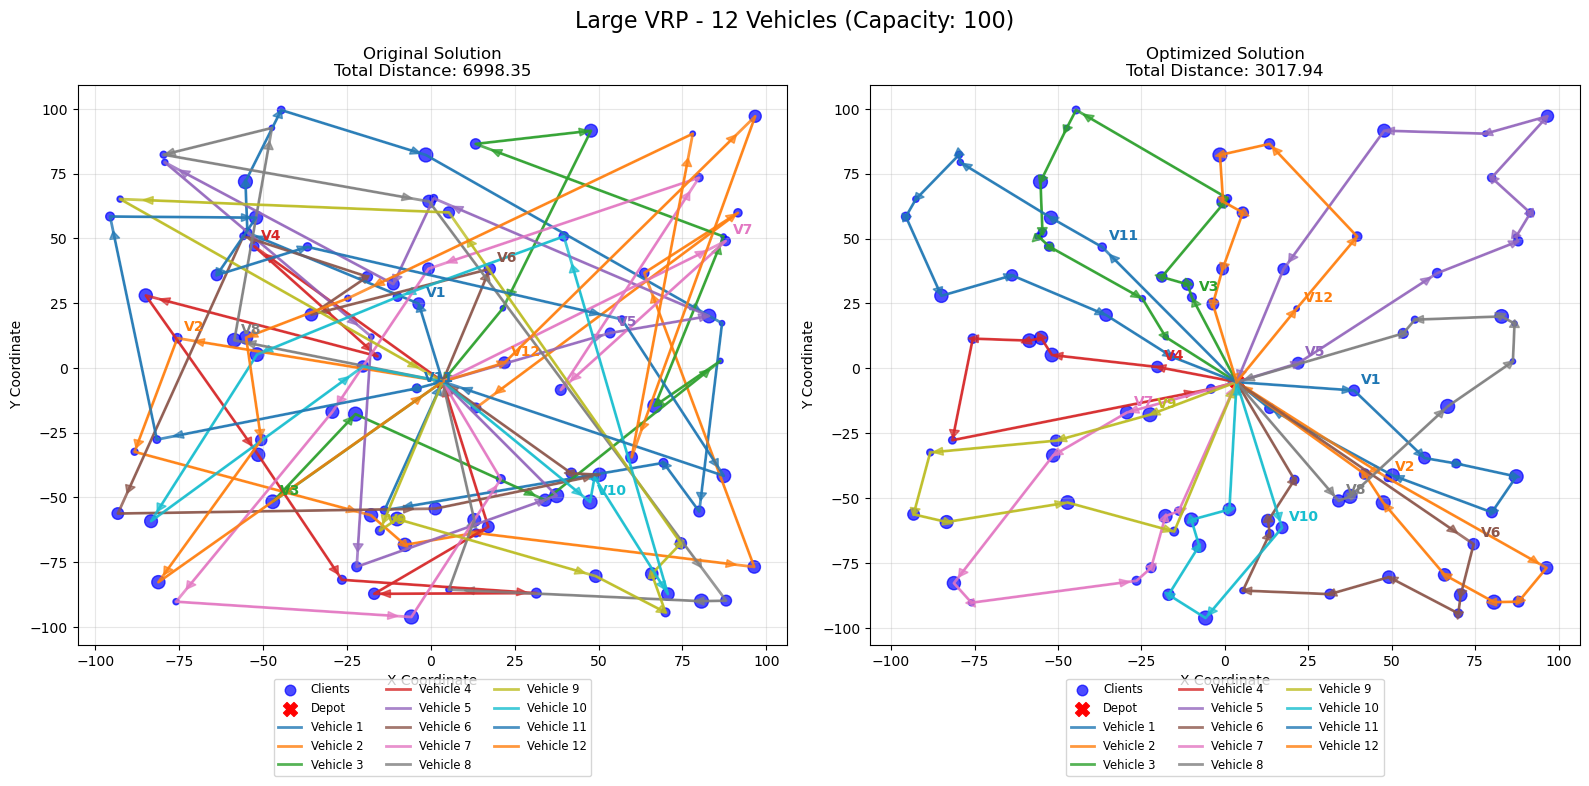


Solution improvement: 56.88%

--------------------------------------------------
CONFIGURATION: 15 vehicles with capacity 100
--------------------------------------------------
Starting LNS with 15 vehicles of capacity 100...
Initial solution distance: 8365.45
Iteration 1: New best distance: 6852.00
Iteration 2: New best distance: 5753.41
Iteration 3: New best distance: 5232.81
Iteration 4: New best distance: 4779.09
Iteration 5: New best distance: 4657.29
Iteration 6: New best distance: 4522.79
Iteration 7: New best distance: 4409.59
Iteration 8: New best distance: 4325.67
Iteration 9: New best distance: 4321.16
Iteration 10: New best distance: 4095.71
Iteration 11: New best distance: 4082.20
Iteration 12: New best distance: 4022.65
Iteration 23: New best distance: 3981.33
Iteration 25: New best distance: 3711.65
Iteration 27: New best distance: 3616.02
Iteration 31: New best distance: 3463.08
Iteration 32: New best distance: 3305.05
Iteration 34: New best distance: 3223.26
Iteration

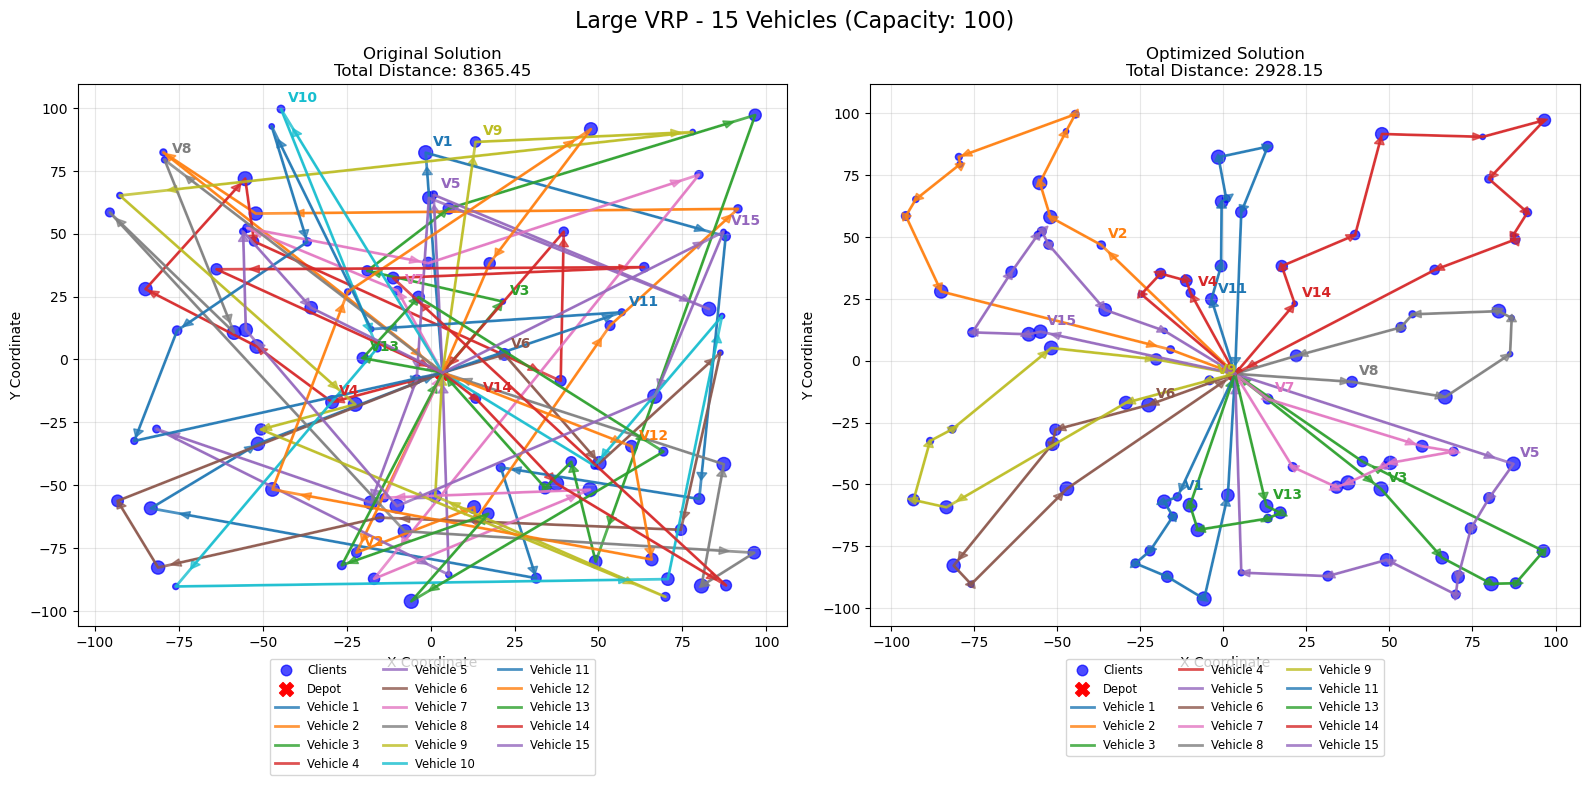


Solution improvement: 65.00%

--------------------------------------------------
CONFIGURATION: 18 vehicles with capacity 100
--------------------------------------------------
Starting LNS with 18 vehicles of capacity 100...
Initial solution distance: 8695.00
Iteration 1: New best distance: 7087.91
Iteration 2: New best distance: 5871.87
Iteration 3: New best distance: 5077.72
Iteration 4: New best distance: 4980.91
Iteration 5: New best distance: 4749.14
Iteration 6: New best distance: 4436.94
Iteration 7: New best distance: 4155.52
Iteration 8: New best distance: 4034.14
Iteration 9: New best distance: 3984.80
Iteration 10: New best distance: 3821.27
Iteration 12: New best distance: 3789.71
Iteration 13: New best distance: 3757.20
Iteration 14: New best distance: 3661.56
Iteration 16: New best distance: 3571.90
Iteration 17: New best distance: 3478.28
Iteration 18: New best distance: 3367.82
Iteration 20: New best distance: 3327.44
Iteration 24: New best distance: 3236.52
Iteration

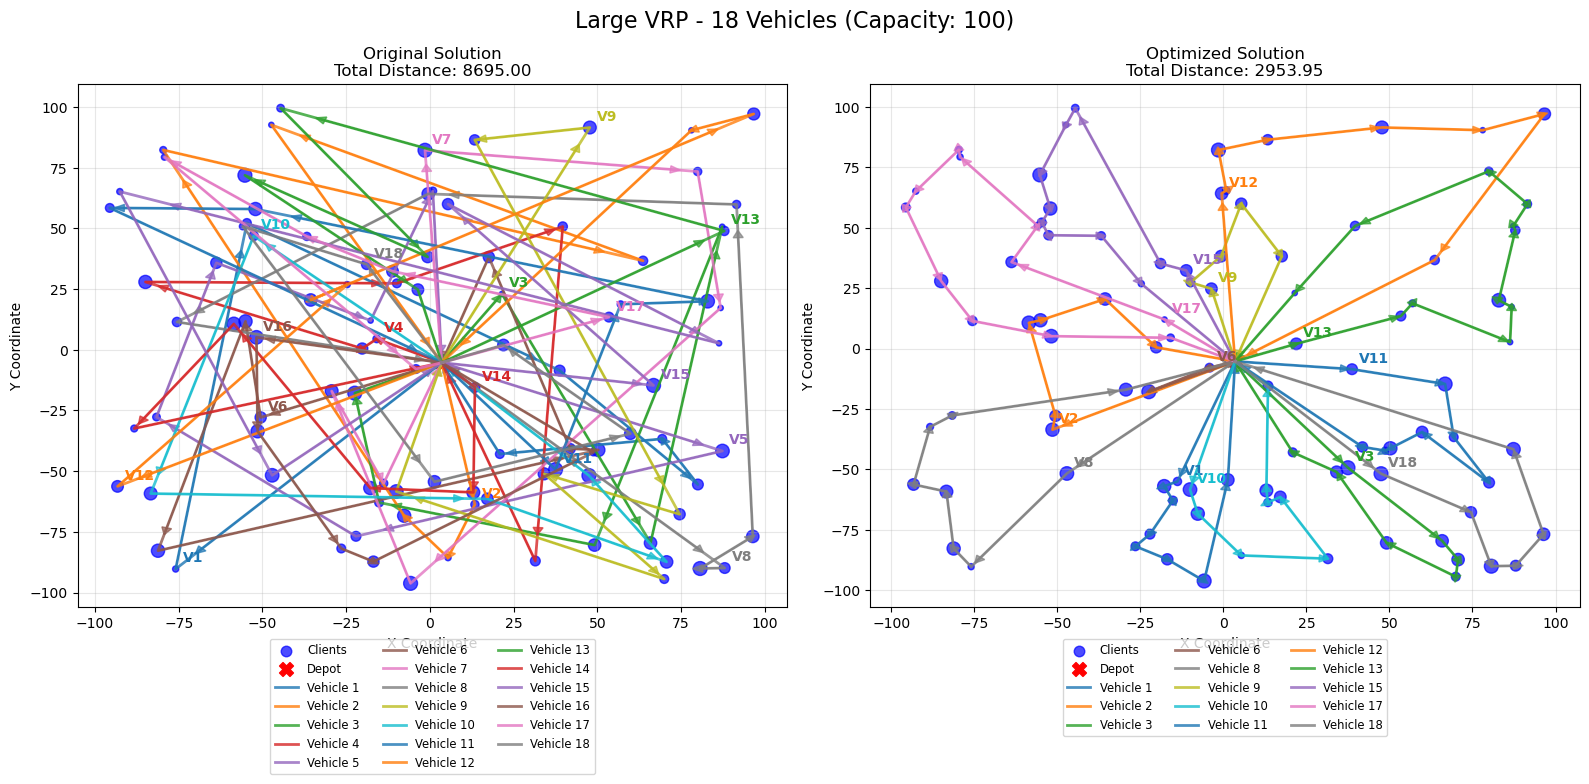


Solution improvement: 66.03%

--------------------------------------------------
CONFIGURATION: 20 vehicles with capacity 100
--------------------------------------------------
Starting LNS with 20 vehicles of capacity 100...
Initial solution distance: 9387.71
Iteration 1: New best distance: 7174.93
Iteration 2: New best distance: 5868.07
Iteration 3: New best distance: 5012.72
Iteration 4: New best distance: 4475.13
Iteration 5: New best distance: 4082.52
Iteration 6: New best distance: 3999.13
Iteration 8: New best distance: 3924.62
Iteration 10: New best distance: 3865.82
Iteration 12: New best distance: 3863.54
Iteration 14: New best distance: 3818.65
Iteration 15: New best distance: 3689.90
Iteration 17: New best distance: 3576.72
Iteration 18: New best distance: 3488.33
Iteration 23: New best distance: 3472.80
Iteration 24: New best distance: 3460.05
Iteration 25: New best distance: 3419.31
Iteration 28: New best distance: 3301.33
Iteration 50: Current distance: 3301.33, Best: 3

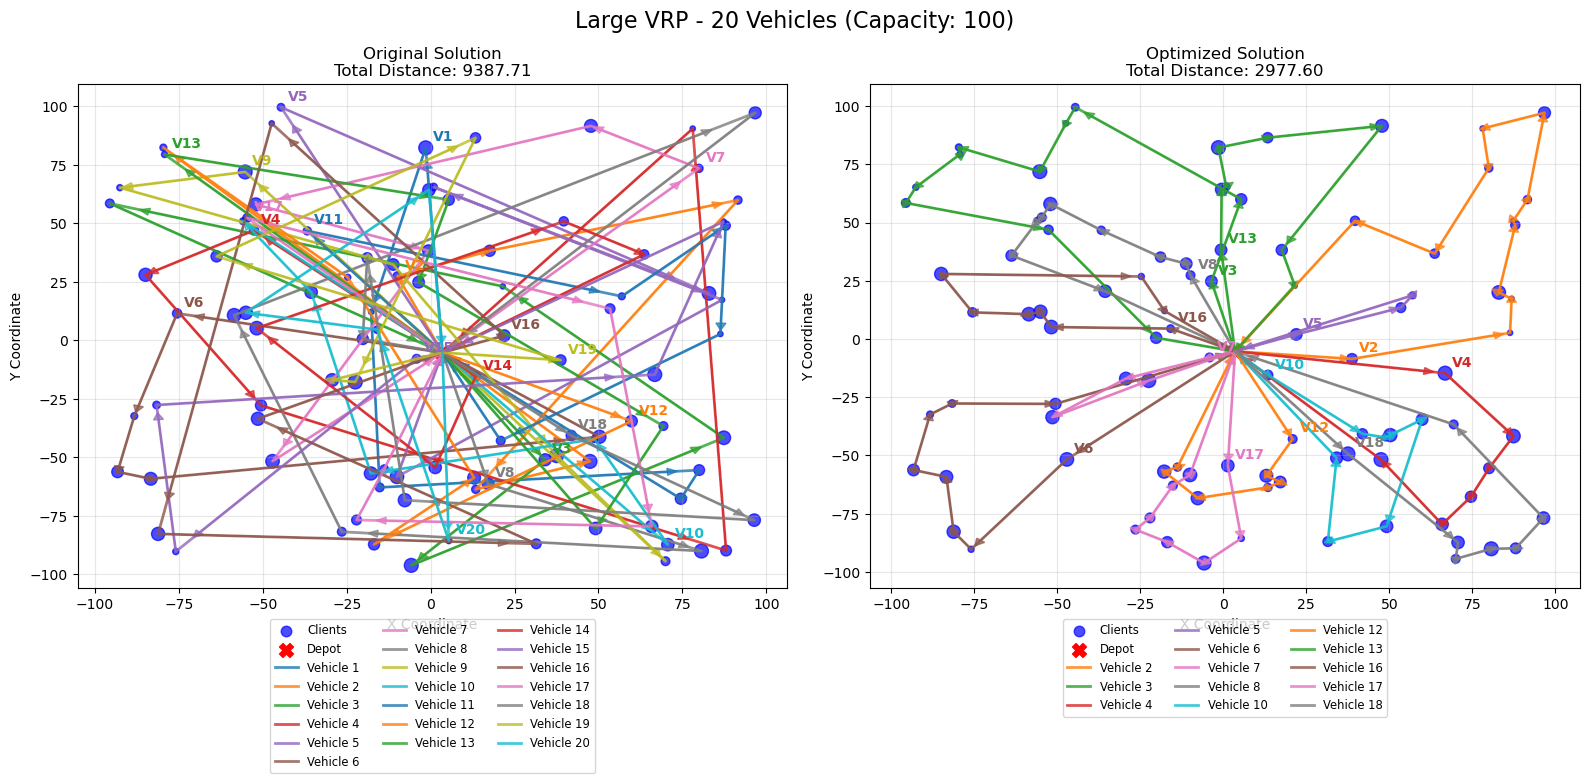


Solution improvement: 68.28%


COMPARISON OF ALL CONFIGURATIONS:
Vehicles   Initial Dist    Final Dist      Improvement     Valid     
----------------------------------------------------------------------
12         6998.35         3017.94         56.88          % ✓
15         8365.45         2928.15         65.00          % ✓
18         8695.00         2953.95         66.03          % ✓
20         9387.71         2977.60         68.28          % ✓

Best VALID configuration: 15 vehicles with distance 2928.15
   Improvement from initial solution: 65.00%


,Vehicle Count,Initial Distance,Final Distance,Improvement (%),Vehicles Used,Valid,Clients Visited
0,12,6998.348274,3017.935366,56.876462,12,True,99/99
1,15,8365.448984,2928.149523,64.997103,13,True,99/99
2,18,8694.997697,2953.946150,66.027062,13,True,99/99
3,20,9387.713487,2977.603122,68.281913,13,True,99/99


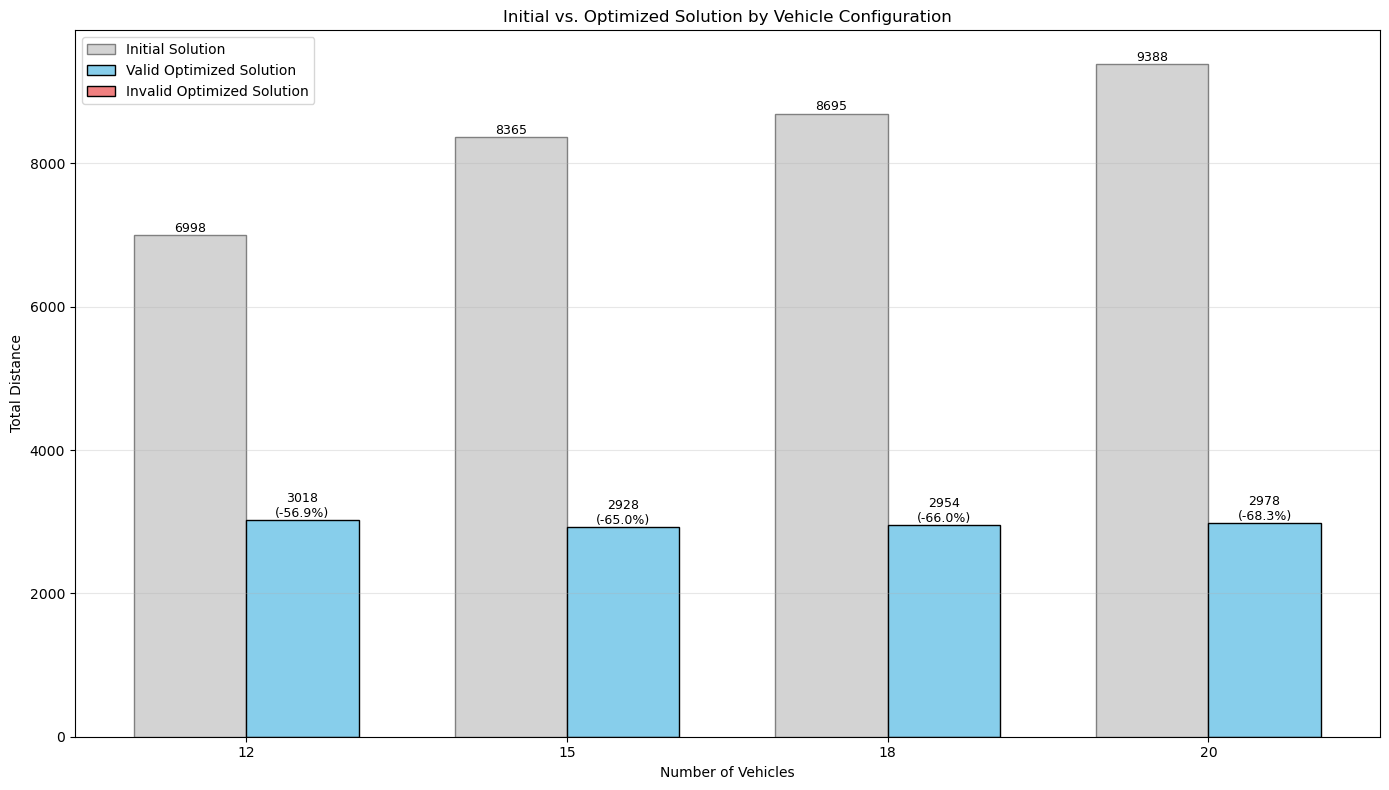

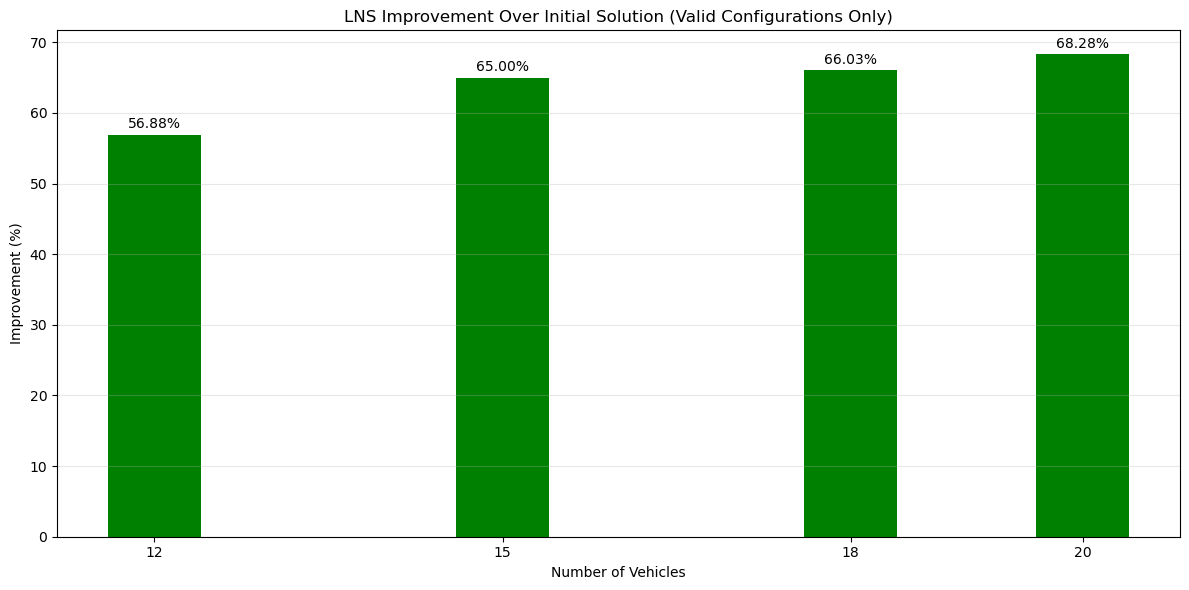



ANALYSIS OF VEHICLE EFFICIENCY:
Vehicles   Distance        Dist/Vehicle    Capacity Util  
------------------------------------------------------------
12         3017.94         251.49          97.3%
15         2928.15         225.24          77.9%
18         2953.95         227.23          64.9%
20         2977.60         229.05          58.4%


,Vehicle Count,Total Distance,Distance per Vehicle,Capacity Utilization (%)
0,12,3017.935366,251.494614,97.333333
1,15,2928.149523,225.242271,77.866667
2,18,2953.946150,227.226627,64.888889
3,20,2977.603122,229.046394,58.400000


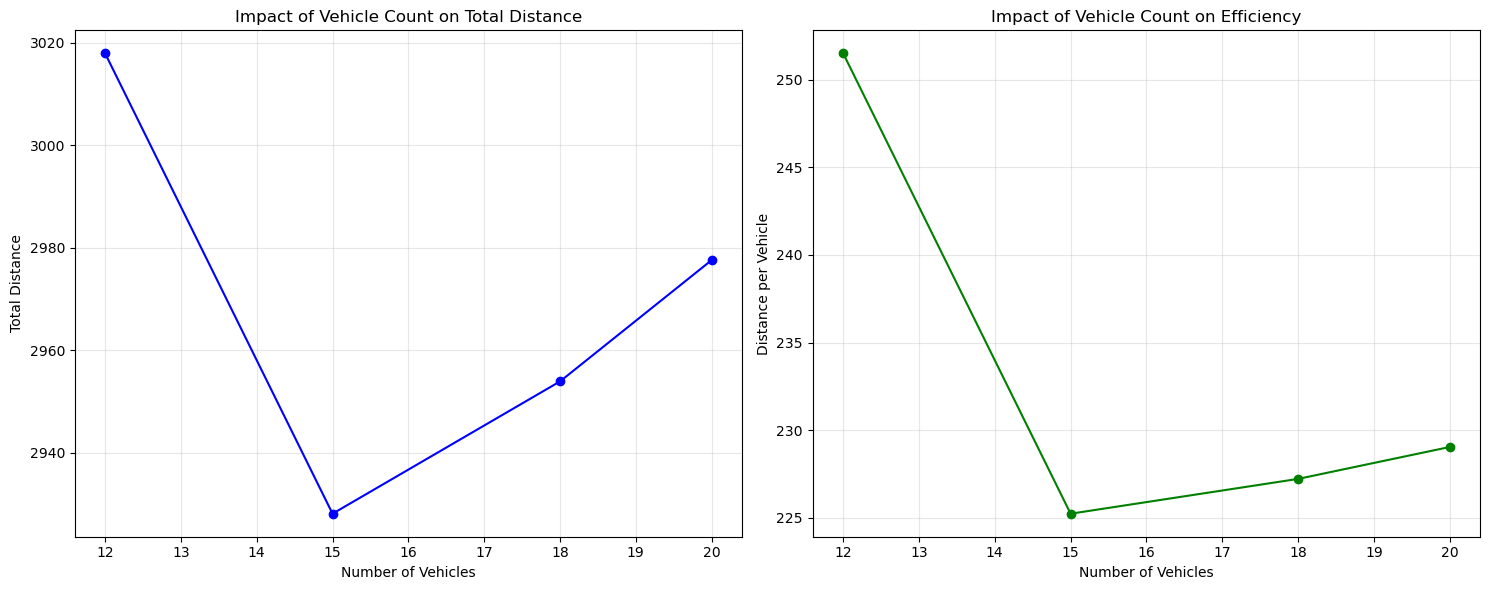


Configuration with minimum total distance: 15.0 vehicles
Configuration with minimum distance per vehicle: 15.0 vehicles


In [93]:
# Run the large VRP analysis with solution comparison
large_results, large_valid_results = solve_large_vrp_with_various_vehicle_counts()